In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from datetime import datetime
from tqdm import tqdm

In [6]:

""" to load all the data from the specific domain with index domain_idx
This function is in a iteration, we need to load each user's data from this func.
:param domain_idx: userid, the filename
:return: X and y data of the entire domain
X.shape(Windowsize, dim), y.shape(windowsize), domain(windowsize)
"""

domain_idx = 'ome'

root_path, _ = os.path.split(os.path.abspath(os.getcwd()))

data_dir = os.path.join(root_path, 'data','omeData', 'raw')
saved_filename = os.path.join(root_path, 'data','omeData', 'omewd', domain_idx + '_wd.data') # "wd": with domain label

datapath = os.path.join(data_dir, '20150715_105700_acc2.csv')

# print('reading data ...')
data_df = pd.read_csv(datapath)
data_df.dropna(axis=0, how='any', inplace=True)
d_df = data_df[['timestamp', 'x', 'y', 'z']].copy()


In [9]:
labelpath = os.path.join(data_dir, 'labels_OME_TestingboardA_shosai.csv')
label_df = pd.read_csv(labelpath)

In [42]:
# Convert strings to datetime objects
format_acc = '%Y%m%d_%H:%M:%S.%f'
format_label = '%Y-%m-%dT%H:%M:%S.%f'

d_df['timestamp'] = d_df.timestamp.map(lambda x: datetime.strptime(x, format_acc))
label_df['start'] = label_df.start.map(lambda x: datetime.strptime(x, format_label))
label_df['end'] = label_df.end.map(lambda x: datetime.strptime(x, format_label))

In [43]:
d_df['period'] = -1
d_df['operation'] = -1

In [44]:
# process label csv

jobid_list = ['job0-', 'job1-', 'job2-', 'job3-', 'job4-', 'job5-', 'job6-', 'job7-', 'job8-','job9-', 'job10-', 'job11-', 'job12-', 'job13-']
opeid_list = ['kibantoritsuke', 'ABB', 'RBOffset', 'ukedai', 'AGC&FlexFilter', 'Blooming', 'Head', 'kibanharaidashi']
ope_dict = dict(zip(opeid_list, np.arange(len(opeid_list))))
label_df['event_typeID'] = label_df['event_type'].apply(lambda x: next((value for value in jobid_list if value in x), None))
label_df['period'] = label_df['event_typeID'].map(lambda x: int(x[3:-1]))
label_df['opeID'] = label_df['event_type'].apply(lambda x: next((value for value in opeid_list if value in x), None))
label_df['operation'] = label_df['opeID'].map(lambda x: ope_dict[x])
label_df2 = label_df[['start', 'end', 'operation', 'period']]


In [62]:
# label_df2: change end time to next start time

end1 = label_df2.start.values[1:]
end2 = np.concatenate([end1,[label_df2.end.values[-1]]],axis=0)
label_df3 = label_df2.copy()
label_df3['end'] = end2

numpy.datetime64('2015-07-15T11:23:35.259000000')

In [63]:
datatime_np = d_df.timestamp.values
data_period = d_df.period.values
data_ope = d_df.operation.values

for index_data, t in tqdm(enumerate(datatime_np), total=len(datatime_np)):
    # Iterate over each label_df row
    for index, row in label_df3.iterrows():
        start = row['start']
        end = row['end']
        operation = row['operation']
        period = row['period']

        # which label
        if (start<=t) and (t<=end):
            data_period[index_data] = period
            data_ope[index_data] = operation
            # print(index_data)
            break


100%|██████████| 97239/97239 [05:22<00:00, 301.51it/s]


In [67]:
d_df['period'] = data_period
d_df['operation'] = data_ope
# Remove rows where Value = -1
d_df = d_df[d_df['operation'] != -1]

In [72]:
GRAVITATIONAL_ACCELERATION = 9.80665
def convert_unit_system(df):
    cols = ["x", "y", "z"]
    df[cols] = df[cols] / GRAVITATIONAL_ACCELERATION
    return df

d_df = convert_unit_system(d_df)


D:\Users\xiqxi\Anaconda3\envs\openpack\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [73]:
d_df.head(2)

,timestamp,x,y,z,period,operation
1012,2015-07-15 10:58:05.111,-0.177205,-0.655608,0.977798,0,0
1013,2015-07-15 10:58:05.128,-0.202589,-0.651703,1.050047,0,0


In [76]:
print('\nProcessing domain {0} files...\n'.format(domain_idx))
X = d_df.values[:, 1:4]  # remove timestamp column
y = d_df.values[:, -1]
d = d_df.values[:, -2]
period = d_df.values[:, -2]
# d = np.full(y.shape, int(domain_dict[domain_idx]), dtype=int)
print('\nProcessing domain {0} files | X: {1} y: {2} d:{3} \n'.format(domain_idx, X.shape, y.shape, d.shape))

obj = [(X, y, d, period)]
f = open(saved_filename, 'wb')
pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()


Processing domain ome files...


Processing domain ome files | X: (95885, 3) y: (95885,) d:(95885,) 



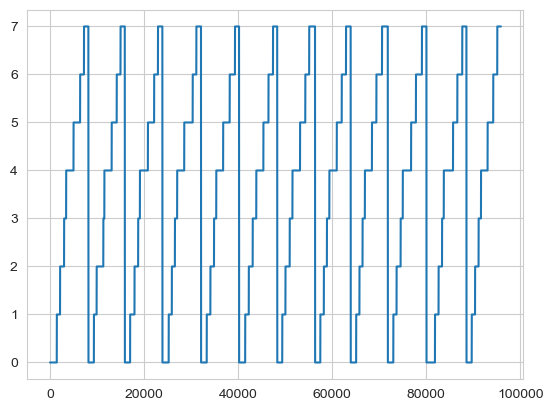

In [81]:
plt.plot(y)
plt.show()